Imports

In [3]:
import tensorflow as tf
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

Constants

In [6]:
IMAGE_PATH = "original.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

Helper Functions

In [8]:
def preprocess_image(image_path):
    #Debugging
    print(f"Processing image: {image_path}")
    image = tf.image.decode_image(tf.io.read_file(image_path))

    if image is None:
        print("Image is None.")
        return None
    
    
    image = tf.image.decode_image(tf.io.read_file(image_path))
    # removing alpha channel if exists as ESRGAN does not take 4 channels
    if image.shape[-1] == 4:
        image = image[...,: -1]
    # Ensure that the image dimensions are multiples of 4 (ESRGAN requires this)
    size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
    image = tf.image.crop_to_bounding_box(image, 0, 0, size[0], size[1])

    # Convert the image to float32
    image = tf.cast(image, tf.float32)

    # Add an extra dimension to represent the batch size
    return tf.expand_dims(image, 0)
  
def save_image(image, filename):
    
    if not isinstance(image, Image.Image):
        # Clip pixel values to the range [0, 255] and convert to a PIL Image
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    # Save the image as a JPEG file
    image.save("%s.jpg" % filename)
    print("Saved as %s.jpg" % filename)

def plot_image(image, title=""):

    # Convert the image tensor to a NumPy array
    image = np.asarray(image)

    # If the tensor has dimensions of size 1, squeeze the tensor
    if image.ndim == 4 and image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)
    
    # Clip pixel values to the range [0, 255] and convert to a PIL Image
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

Upscaling Image

Processing image: original.png
Saved as Original Image.jpg


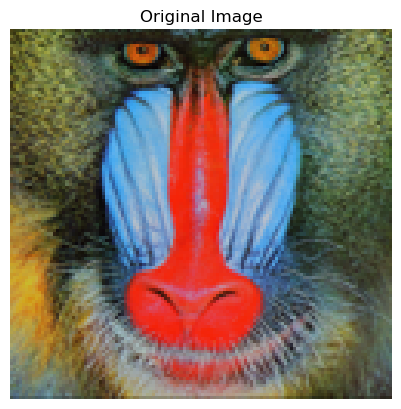

In [11]:
hr_image = preprocess_image(IMAGE_PATH)
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [12]:
model = hub.load(SAVED_MODEL_PATH)

In [13]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 1.143720


Super resolution image

Saved as Super Resolution.jpg


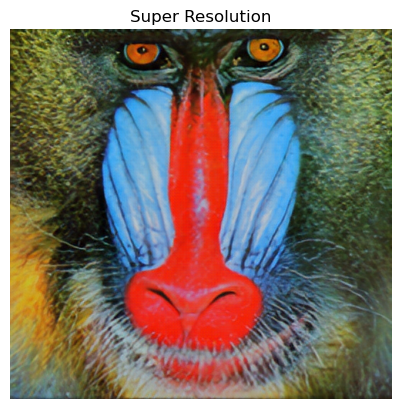

In [14]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

Testing performance of model by applying bicubic down sampling to a high resolution image. Then regenerating the downsampled image into high resolution and using Peak signal to noise ratio as a performance metric